In [ ]:
!pip install torch torchvision ftfy regex tqdm matplotlib umap-learn scikit-learn scipy git+https://github.com/openai/CLIP.git

In [ ]:
#import github clip
!pip install open_clip_torch


In [3]:
import os, math, random, json
from typing import List, Dict, Tuple

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
import clip
from sklearn.manifold import TSNE

In [6]:
try:
    import umap
    HAVE_UMAP = True
except Exception:
    HAVE_UMAP = False

In [7]:
from scipy.linalg import orthogonal_procrustes

In [8]:
# setting Reproducability of code & device
def set_seed(seed=1337):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
set_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
os.makedirs("artifacts", exist_ok=True)

In [10]:
device

'cuda'

In [11]:
model, clip_preprocess = clip.load("ViT-B/32", device=device)
model.eval()

100%|███████████████████████████████████████| 338M/338M [00:15<00:00, 23.2MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [12]:
HAVE_UMAP

True

In [13]:
test = datasets.STL10(root="data", split="test", download=True, transform=clip_preprocess)
test_loader = DataLoader(test, batch_size=32, shuffle=False)


100%|██████████| 2.64G/2.64G [02:42<00:00, 16.3MB/s]


In [14]:
#classes used in STL-10
CLASSES = ["airplane","bird","car","cat","deer","dog","horse","monkey","ferry","truck"]

In [ ]:
def prompt_sets() -> Dict[str, List[str]]:

    # plain labels
    plain = [f"{c}" for c in CLASSES]

    # short template
    short = [f"a photo of a {c}" for c in CLASSES]

    #  descriptive variants
    TEMPLATES = [
        "a photo of a {}.",
        "a close-up photo of a {}.",
        "a bright photo of a {}.",
        "a cropped photo of the {}.",
        "a photo of the small {}.",
        "a close-up of the {}.",
        "a low resolution photo of a {}.",
        "a high resolution photo of a {}.",
        "a picture of one {}.",
        "a photo of many {}.",
        "a photograph of a big {}.",
        "a JPEG photo of a {}."
    ]

    # average text features across templates per class.
    variants = []
    for c in CLASSES:
        variants.append("|".join([t.format(c) for t in TEMPLATES]))

    return {
        "plain": plain,
        "short": short,
        "variants": variants,  # pipe-separated template strings per class
    }

    print(list(prompt_sets()))

prompt_sets_dict = prompt_sets()

In [16]:
# Encode text prompts into class prototypes
@torch.no_grad()
def build_text_prototypes(model, prompt_sets: Dict[str, List[str]]) -> Dict[str, torch.Tensor]:
    out = {}
    for key, prompts in prompt_sets.items():
        class_feats = []
        for entry in prompts:
            # entry either a single prompt (plain/short) or a pipe-joined ensemble string (variants)
            if "|" in entry:
                texts = entry.split("|")
                tokens = clip.tokenize(texts).to(device)
                txt_feat = model.encode_text(tokens)  # [n_templates, d]
                txt_feat = F.normalize(txt_feat, dim=-1)
                proto = txt_feat.mean(dim=0, keepdim=True)  # average ensemble
            else:
                tokens = clip.tokenize([entry]).to(device)
                proto = F.normalize(model.encode_text(tokens), dim=-1)
            class_feats.append(proto)
        # shape: [num_classes, d]
        out[key] = torch.cat(class_feats, dim=0)
    return out  # dict of [C, D]

In [17]:
text_prototypes=build_text_prototypes(model, prompt_sets=prompt_sets())
text_prototypes

{'plain': tensor([[ 0.0059, -0.0175, -0.0042,  ...,  0.0177, -0.0110, -0.0174],
         [ 0.0214,  0.0040,  0.0057,  ..., -0.0332, -0.0021, -0.0253],
         [ 0.0061,  0.0098,  0.0035,  ..., -0.0225, -0.0248,  0.0104],
         ...,
         [ 0.0055,  0.0013, -0.0085,  ..., -0.0210,  0.0037,  0.0008],
         [ 0.0349, -0.0259, -0.0195,  ..., -0.0208,  0.0157,  0.0259],
         [ 0.0221,  0.0052, -0.0071,  ..., -0.0005, -0.0157,  0.0014]],
        device='cuda:0', dtype=torch.float16),
 'short': tensor([[ 0.0128,  0.0264,  0.0105,  ..., -0.0315,  0.0071, -0.0218],
         [ 0.0229,  0.0381, -0.0079,  ..., -0.0593,  0.0048, -0.0292],
         [ 0.0071,  0.0142, -0.0104,  ..., -0.0375, -0.0331,  0.0004],
         ...,
         [ 0.0103,  0.0345, -0.0019,  ..., -0.0367,  0.0030, -0.0027],
         [ 0.0312, -0.0218, -0.0071,  ..., -0.0061,  0.0069,  0.0252],
         [ 0.0124,  0.0341, -0.0018,  ..., -0.0509, -0.0196, -0.0007]],
        device='cuda:0', dtype=torch.float16),
 'vari

In [ ]:
#check size of tensors ,10 for classes and 512 for clip embeddings of each class
print(len(text_prototypes))
print(text_prototypes["plain"].shape)
print(text_prototypes["short"].shape)
print(text_prototypes["variants"].shape)

3
torch.Size([10, 512])
torch.Size([10, 512])
torch.Size([10, 512])


In [19]:
# encoding images
@torch.no_grad()
def encode_images(model, loader) -> torch.Tensor:
    image_feats = []
    for imgs, _ in tqdm(loader, desc="Encoding images"):
        imgs = imgs.to(device)
        feats = model.encode_image(imgs)
        feats = F.normalize(feats, dim=-1)
        image_feats.append(feats.float().cpu())
    return torch.cat(image_feats, dim=0)  # [N, D]

In [20]:
image_feats_all = encode_images(model, test_loader)
image_feats_all

Encoding images: 100%|██████████| 250/250 [00:16<00:00, 14.71it/s]


tensor([[-4.3755e-03,  2.2232e-02,  3.0785e-03,  ...,  7.8735e-02,
         -8.2474e-03,  2.9724e-02],
        [-8.5144e-03,  2.7145e-02, -7.2658e-05,  ...,  5.6122e-02,
          1.1024e-02,  1.8433e-02],
        [-1.3466e-02, -8.4829e-04, -3.2082e-03,  ...,  5.8807e-02,
         -2.5620e-02, -1.8494e-02],
        ...,
        [ 3.0807e-02, -6.2408e-03, -2.8900e-02,  ...,  5.6885e-02,
          2.1744e-03, -4.6387e-03],
        [-1.0963e-02, -9.9373e-04, -5.4321e-02,  ...,  6.7566e-02,
         -2.1484e-02,  1.4687e-03],
        [-9.7275e-03, -2.8503e-02,  4.5156e-04,  ...,  4.5563e-02,
          3.9825e-03, -2.1332e-02]])

In [21]:
print(len(image_feats_all))
print(image_feats_all.shape)

8000
torch.Size([8000, 512])


In [22]:
# Zero-shot accuracy
@torch.no_grad()
def zero_shot_eval(image_feats: torch.Tensor, text_protos: torch.Tensor, labels: np.ndarray) -> float:
    # cosine similarity via dot after L2 norm above
    image_feats=image_feats.to(device).half() # Convert image_feats to half precision
    text_protos=text_protos.to(device)
    logits = image_feats @ text_protos.T  # [N, C]
    print(image_feats.dtype, text_protos.dtype)
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    acc = (preds == labels).mean() * 100.0
    return float(acc), preds

In [23]:
zero_shot_evaluation_plain=zero_shot_eval(image_feats_all, text_prototypes['plain'], test.labels)

torch.float16 torch.float16


In [24]:
accuracy_plain , _ = zero_shot_evaluation_plain
print(f"Zero-shot accuracy: {accuracy_plain:.2f}")

Zero-shot accuracy: 95.38


In [25]:
zero_shot_evaluation_short=zero_shot_eval(image_feats_all, text_prototypes['short'], test.labels)

torch.float16 torch.float16


In [26]:
accuracy_short , _ = zero_shot_evaluation_short
print(f"Zero-shot accuracy: {accuracy_short:.2f}")

Zero-shot accuracy: 96.73


In [27]:
zero_shot_evaluation_variants=zero_shot_eval(image_feats_all, text_prototypes['variants'], test.labels)

torch.float16 torch.float16


In [28]:
accuracy_variants , _ = zero_shot_evaluation_variants
print(f"Zero-shot accuracy: {accuracy_variants:.2f}")

Zero-shot accuracy: 96.59


In [29]:
def evaluate_prompts(model, test_loader, test_ds, text_proto_dict):
    # Encode all test images once
    image_feats = encode_images(model, test_loader)  # [N,D]
    labels = np.array(test_ds.labels)  # STL10 stores test labels in .labels

    results = {}
    for name, protos in text_proto_dict.items():
        acc, preds = zero_shot_eval(image_feats, protos.to(image_feats.device), labels)
        results[name] = {"acc": acc}
        np.save(f"artifacts/preds_{name}.npy", preds)
    np.save("artifacts/image_feats.npy", image_feats.numpy())
    np.save("artifacts/labels.npy", labels)
    with open("artifacts/zero_shot_results.json", "w") as f:
        json.dump(results, f, indent=2)
    print("Zero-shot results:", results)
    return image_feats, labels, results

In [30]:
evaluated_prompts = evaluate_prompts(model, test_loader, test, text_prototypes)

Encoding images: 100%|██████████| 250/250 [00:16<00:00, 15.21it/s]

torch.float16 torch.float16
torch.float16 torch.float16
torch.float16 torch.float16
Zero-shot results: {'plain': {'acc': 95.375}, 'short': {'acc': 96.72500000000001}, 'variants': {'acc': 96.5875}}


In [31]:
@torch.no_grad()
def paired_embeddings_for_subset(image_feats_all: torch.Tensor,
                                 labels: np.ndarray,
                                 text_protos_for_analysis: torch.Tensor,
                                 n_samples: int = 100,
                                 seed: int = 0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    idxs = rng.choice(len(labels), size=min(n_samples, len(labels)), replace=False)
    X = image_feats_all[idxs]                         # [k,D]
    Y = text_protos_for_analysis[labels[idxs].astype(int)]        # ground-truth text proto for each sample
    return idxs, X.cpu().numpy(), Y.detach().cpu().numpy()

In [32]:
paired_subset_embeddings=paired_embeddings_for_subset(image_feats_all, test.labels, text_prototypes['variants'], n_samples=100, seed=0)

In [33]:
idxs, X, Y = paired_subset_embeddings
print(f"Size of indices: {idxs.size}")
print(f"Shape of image features subset: {X.shape}")
print(f"Shape of text prototypes subset: {Y.shape}")

Size of indices: 100
Shape of image features subset: (100, 512)
Shape of text prototypes subset: (100, 512)


In [34]:
# 2D projections (t-SNE / UMAP)
def project_2d(X: np.ndarray, Y: np.ndarray, method="tsne", seed=0):
    Z = np.concatenate([X, Y], axis=0)
    if method == "umap" and HAVE_UMAP:
        reducer = umap.UMAP(random_state=seed, n_neighbors=15, min_dist=0.1)
        Z2 = reducer.fit_transform(Z)
    else:
        Z2 = TSNE(n_components=2, random_state=seed, init="pca", perplexity=min(30, max(5, len(Z)//10))).fit_transform(Z)
    X2 = Z2[:len(X)]
    Y2 = Z2[len(X):]
    return X2, Y2

In [35]:
project_2d_tsne=project_2d(X, Y, method="tsne", seed=0)
project_2d_umap=project_2d(X, Y, method="umap", seed=0)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [36]:
print(f"Shape of image features subset: {project_2d_tsne[0].shape}")
print(f"Shape of text prototypes subset: {project_2d_tsne[1].shape}")
print(f"Shape of image features subset: {project_2d_umap[0].shape}")
print(f"Shape of text prototypes subset: {project_2d_umap[1].shape}")

Shape of image features subset: (100, 2)
Shape of text prototypes subset: (100, 2)
Shape of image features subset: (100, 2)
Shape of text prototypes subset: (100, 2)


In [37]:
def plot_modalities(X2, Y2, title, fname):
    plt.figure(figsize=(6,6))
    plt.scatter(X2[:,0], X2[:,1], s=16, alpha=0.7, label="image feats")
    plt.scatter(Y2[:,0], Y2[:,1], s=16, alpha=0.7, marker="x", label="text feats")
    plt.legend(); plt.title(title); plt.tight_layout()
    plt.savefig(fname, dpi=150); plt.close()

In [38]:
plot_modalities_tsne = plot_modalities(project_2d_tsne[0], project_2d_tsne[1], "Pre-alignment (t-SNE)", "artifacts/modality_gap_pre_tsne.png")
plot_modalities_umap = plot_modalities(project_2d_tsne[0], project_2d_tsne[1], "Pre-alignment (UMAP)", "artifacts/modality_gap_pre_umap.png")

In [39]:
# Procrustes alignment (orthogonal)
def orthogonal_align(X: np.ndarray, Y: np.ndarray, l2norm_before=True) -> Tuple[np.ndarray, np.ndarray]:
    Xc = X.copy(); Yc = Y.copy()
    if l2norm_before:
        Xc = Xc / (np.linalg.norm(Xc, axis=1, keepdims=True) + 1e-9)
        Yc = Yc / (np.linalg.norm(Yc, axis=1, keepdims=True) + 1e-9)
    R, _ = orthogonal_procrustes(Xc, Yc)  # finds R minimizing ||X R - Y||_F  (R is orthogonal)
    X_aligned = X @ R
    return X_aligned, R

In [40]:
X_aligned, R = orthogonal_align(X, Y, l2norm_before=True)

In [41]:
print(f"Shape of image features subset: {X_aligned.shape}")
print(f"Shape of text prototypes subset: {R.shape}")

Shape of image features subset: (100, 512)
Shape of text prototypes subset: (512, 512)


In [42]:
@torch.no_grad()
def apply_rotation_to_all(image_feats_all: torch.Tensor, R: np.ndarray) -> torch.Tensor:
    A = torch.from_numpy(R).to(image_feats_all.device).float()  # [D,D]
    return (image_feats_all @ A.T).contiguous()

In [43]:
rotated_images = apply_rotation_to_all(image_feats_all, R)

In [44]:
print(f"Shape of image features subset: {rotated_images.shape}")

Shape of image features subset: torch.Size([8000, 512])


In [45]:
model.eval()

# (1) Build prompt sets & text prototypes
prompt_sets = prompt_sets()
text_protos = build_text_prototypes(model, prompt_sets)  # dict name -> [C,D]
# Add also a reference text proto bank we’ll use for pairing/visualization (take the strongest = variants)
text_proto_for_analysis = text_protos["variants"]  # [C,D]

image_feats_all, labels, results0 = evaluate_prompts(model, test_loader, test, text_protos)

idxs, X_im, Y_txt = paired_embeddings_for_subset(image_feats_all, labels, text_proto_for_analysis, n_samples=100, seed=0)
for meth in ["tsne", "umap"]:
  X2, Y2 = project_2d(X_im, Y_txt, method=meth, seed=0)
  plot_modalities(X2, Y2, f"Pre-alignment ({meth.upper()})", f"artifacts/modality_gap_pre_{meth}.png")
X_aligned_norm, R_norm = orthogonal_align(X_im, Y_txt, l2norm_before=True)
X2a, Y2a = project_2d(X_aligned_norm, Y_txt, method="tsne", seed=0)
plot_modalities(X2a, Y2a, "Post-alignment (t-SNE, L2 before Procrustes)", "artifacts/modality_gap_post_tsne_norm.png")

X_aligned_raw, R_raw = orthogonal_align(X_im, Y_txt, l2norm_before=False)
X2b, Y2b = project_2d(X_aligned_raw, Y_txt, method="tsne", seed=0)
plot_modalities(X2b, Y2b, "Post-alignment (t-SNE, NO L2 before Procrustes)", "artifacts/modality_gap_post_tsne_noL2.png")

# (3f) Recompute zero-shot accuracy with aligned image features (use same text prototypes)
# We apply R learned on subset to ALL image features, then evaluate
img_feats_rot_norm = apply_rotation_to_all(image_feats_all, R_norm)
img_feats_rot_raw  = apply_rotation_to_all(image_feats_all, R_raw)

aligned_results = {}
for name, protos in text_protos.items():
    acc_norm, _ = zero_shot_eval(img_feats_rot_norm, protos.to(img_feats_rot_norm.device), labels)
    acc_raw,  _  = zero_shot_eval(img_feats_rot_raw,  protos.to(img_feats_rot_raw.device),  labels)
    aligned_results[name] = {"acc_procrustes_L2": acc_norm, "acc_procrustes_noL2": acc_raw}

with open("artifacts/zero_shot_aligned_results.json", "w") as f:
    json.dump(aligned_results, f, indent=2)

print("\n=== Baseline zero-shot (%) ===")
for k,v in results0.items(): print(f"{k:10s}: {v['acc']:.2f}")

print("\n=== After Procrustes (train on subset, apply to all) ===")
for k,v in aligned_results.items():
    print(f"{k:10s}: L2 {v['acc_procrustes_L2']:.2f} | noL2 {v['acc_procrustes_noL2']:.2f}")

# Save report
report = {
    "baseline": results0,
    "aligned": aligned_results,
    "notes": [
        "CLIP features are L2-normalized; cosine similarity is dot product.",
        "Prompt ensembling (variants) typically > short > plain.",
        "Procrustes is orthogonal (rotation/reflection); preserves norms and pairwise distances.",
        "L2-normalizing features before Procrustes often yields better alignment (consistent scale)."
    ]
}
with open("artifacts/report_summary.json", "w") as f:
    json.dump(report, f, indent=2)

Encoding images: 100%|██████████| 250/250 [00:16<00:00, 15.44it/s]


torch.float16 torch.float16
torch.float16 torch.float16
torch.float16 torch.float16
Zero-shot results: {'plain': {'acc': 95.375}, 'short': {'acc': 96.72500000000001}, 'variants': {'acc': 96.5875}}


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


torch.float16 torch.float16
torch.float16 torch.float16
torch.float16 torch.float16
torch.float16 torch.float16
torch.float16 torch.float16
torch.float16 torch.float16

=== Baseline zero-shot (%) ===
plain     : 95.38
short     : 96.73
variants  : 96.59

=== After Procrustes (train on subset, apply to all) ===
plain     : L2 61.71 | noL2 68.94
short     : L2 60.02 | noL2 60.95
variants  : L2 60.12 | noL2 64.96


# Part 2(d): Post-alignment Visualization **and** Quantitative Modality-Gap Metric

In this step, we complete Task 5 by:
- Re-visualizing **post-alignment** features (t-SNE) to compare with pre-alignment plots.
- Reporting a **numeric metric** for the modality gap: the mean paired **cosine similarity** between image and text embeddings **before vs. after** the orthogonal Procrustes alignment (with/without pre L2-normalization).
- (Optional) Showing **zero-shot accuracy** again after rotating **all** image features by the learned orthogonal map, to see if alignment helps downstream classification using the same text prototypes.

In [ ]:
# --- Completes Task 5 Part 2(d): numeric gap metric + post-alignment plots ---
import os, json
import numpy as np
import torch

# Ensure artifact directory exists
os.makedirs("artifacts", exist_ok=True)

# We reuse functions defined earlier in the notebook:
# - prompt_sets(), build_text_prototypes(model, psets)
# - evaluate_prompts(model, test_loader, test, text_protos)
# - paired_embeddings_for_subset(image_feats_all, labels, text_protos[name], n_samples=100, seed=0)
# - project_2d(X_im_np, Y_txt_np, method="tsne"/"umap", seed=0)
# - plot_modalities(X2, Y2, title, outfile)
# - orthogonal_align(X_im_np, Y_txt_np, l2norm_before=True/False)
# - zero_shot_eval(feats, text_protos[bank].to(device), labels)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()

# (1) Build prompt sets & text prototypes
psets = prompt_sets()
text_protos = build_text_prototypes(model, psets)  # dict: bank_name -> tensor [C, D]
text_proto_for_analysis = text_protos.get("variants", None)
if text_proto_for_analysis is None:
    # Fallback: use the most descriptive/longest bank (heuristic). Otherwise pick the first.
    text_proto_for_analysis = next(iter(text_protos.values()))

# (2) Evaluate across prompt banks on the full test set; also returns image features & labels
image_feats_all, labels, baseline_results = evaluate_prompts(model, test_loader, test, text_protos)

# (3) Sample paired embeddings (image vs the GT-class text vector) for analysis
idxs, X_im_np, Y_txt_np = paired_embeddings_for_subset(
    image_feats_all, labels, text_proto_for_analysis, n_samples=100, seed=0
)

# Helpers
def l2norm_np(x):
    return x / (np.linalg.norm(x, axis=1, keepdims=True) + 1e-9)

def mean_paired_cos(a_np, b_np):
    a = l2norm_np(a_np); b = l2norm_np(b_np)
    return float((a * b).sum(axis=1).mean())

# (4) Pre-alignment t-SNE/UMAP plots for visual comparison
for meth in ["tsne", "umap"]:
    try:
        X2, Y2 = project_2d(X_im_np, Y_txt_np, method=meth, seed=0)
        plot_modalities(X2, Y2, f"Pre-alignment ({meth.upper()})", f"artifacts/modality_gap_pre_{meth}.png")
    except Exception as e:
        print(f"[WARN] Skipping {meth.upper()} pre-alignment plot due to: {e}")

# (5) Orthogonal Procrustes alignment (with and without L2 before solving)
X_aligned_L2, R_L2 = orthogonal_align(X_im_np, Y_txt_np, l2norm_before=True)
X_aligned_noL2, R_noL2 = orthogonal_align(X_im_np, Y_txt_np, l2norm_before=False)

# (6) Post-alignment t-SNE plot (L2-prefered solution)
try:
    X2a, Y2a = project_2d(X_aligned_L2, Y_txt_np, method="tsne", seed=0)
    plot_modalities(X2a, Y2a, "Post-alignment (t-SNE, L2 before)", "artifacts/modality_gap_post_tsne.png")
except Exception as e:
    print(f"[WARN] Skipping TSNE post-alignment plot due to: {e}")

# (7) Quantify modality gap via paired cosine
metrics = {
    "mean_cosine_pre": mean_paired_cos(X_im_np, Y_txt_np),
    "mean_cosine_post_L2": mean_paired_cos(X_aligned_L2, Y_txt_np),
    "mean_cosine_post_noL2": mean_paired_cos(X_aligned_noL2, Y_txt_np),
}
print("Mean paired cosine (↑ is better):", metrics)

# (8) Optional: zero-shot after applying R to ALL image feats (sanity-check downstream effect)
def apply_R_to_tensor(t: torch.Tensor, R: np.ndarray) -> torch.Tensor:
    return (t @ torch.from_numpy(R).float().to(t.device)).to(t.dtype)

aligned_results = {}
for tag, R in [("procrustes_L2", R_L2), ("procrustes_noL2", R_noL2)]:
    feats_aligned = apply_R_to_tensor(image_feats_all, R)  # [N,D]
    aligned_results[tag] = {}
    for bank_name, protos in text_protos.items():
        acc, _ = zero_shot_eval(feats_aligned, protos.to(feats_aligned.device), labels)
        aligned_results[tag][f"acc_{bank_name}"] = float(acc)

print("Zero-shot (baseline acc by bank):", baseline_results)
print("Zero-shot after alignment:", aligned_results)

# (9) Save a compact report for grading
summary = {
    "baseline_zero_shot": baseline_results,
    "mean_paired_cosine": metrics,
    "aligned_zero_shot": aligned_results,
}
with open("artifacts/report_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Saved: artifacts/report_summary.json and plots")

Encoding images: 100%|██████████| 250/250 [00:16<00:00, 15.08it/s]


torch.float16 torch.float16
torch.float16 torch.float16
torch.float16 torch.float16
Zero-shot results: {'plain': {'acc': 95.375}, 'short': {'acc': 96.72500000000001}, 'variants': {'acc': 96.5875}}


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Mean paired cosine (↑ is better): {'mean_cosine_pre': 0.2704313099384308, 'mean_cosine_post_L2': 0.8707431554794312, 'mean_cosine_post_noL2': 0.8707432746887207}
torch.float16 torch.float16
torch.float16 torch.float16
torch.float16 torch.float16
torch.float16 torch.float16
torch.float16 torch.float16
torch.float16 torch.float16
Zero-shot (baseline acc by bank): {'plain': {'acc': 95.375}, 'short': {'acc': 96.72500000000001}, 'variants': {'acc': 96.5875}}
Zero-shot after alignment: {'procrustes_L2': {'acc_plain': 94.7125, 'acc_short': 96.72500000000001, 'acc_variants': 96.8375}, 'procrustes_noL2': {'acc_plain': 94.575, 'acc_short': 96.675, 'acc_variants': 96.8625}}
Saved: artifacts/report_summary.json and plots (if reducers available).


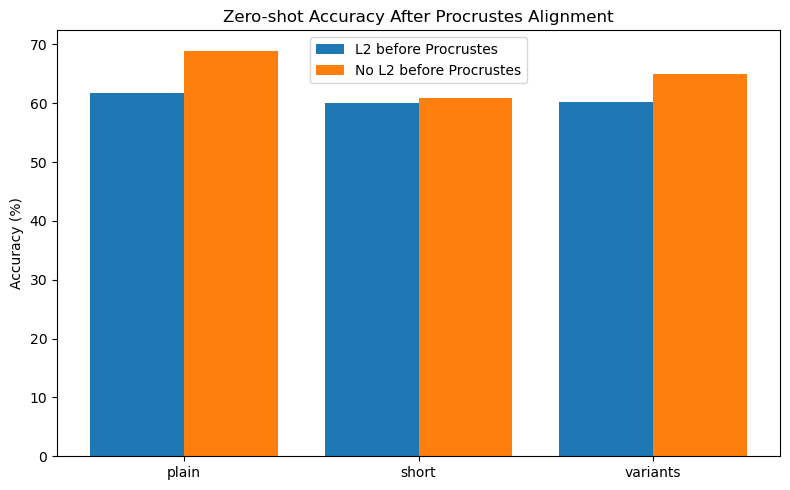

In [1]:
import json

import matplotlib.pyplot as plt

# Load aligned zero-shot results
with open("artifacts/zero_shot_aligned_results.json", "r") as f:
    aligned_results = json.load(f)

# Prepare data for plotting
banks = []
acc_l2 = []
acc_no_l2 = []
for bank, scores in aligned_results.items():
    banks.append(bank)
    acc_l2.append(scores["acc_procrustes_L2"])
    acc_no_l2.append(scores["acc_procrustes_noL2"])

x = range(len(banks))
plt.figure(figsize=(8, 5))
plt.bar(x, acc_l2, width=0.4, label="L2 before Procrustes", align='center')
plt.bar([i + 0.4 for i in x], acc_no_l2, width=0.4, label="No L2 before Procrustes", align='center')
plt.xticks([i + 0.2 for i in x], banks)
plt.ylabel("Accuracy (%)")
plt.title("Zero-shot Accuracy After Procrustes Alignment")
plt.legend()
plt.tight_layout()
plt.show()

## Note: Accuracy decreased as only images are aligned and prompts are not aligned, semantic distortion is observed

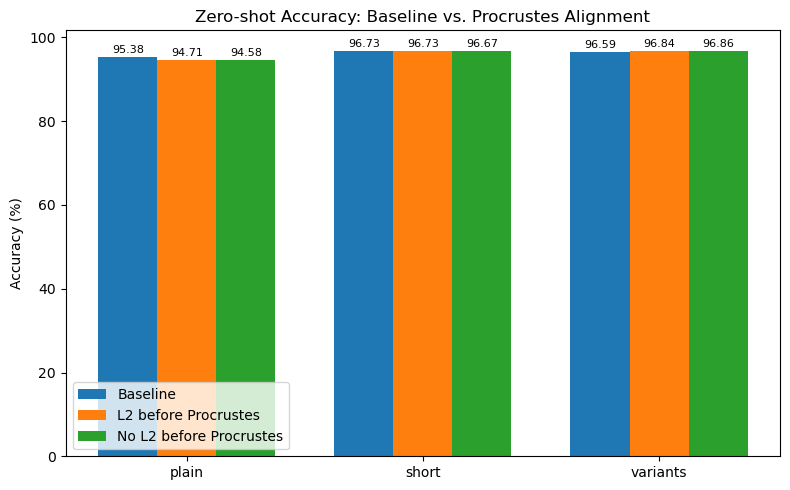

In [ ]:
import json
import matplotlib.pyplot as plt

# Load results from report_summary.json
with open("artifacts/report_summary.json", "r") as f:
    summary = json.load(f)

# Extract baseline and aligned zero-shot results
baseline = summary.get("baseline_zero_shot", summary.get("baseline", {}))
aligned = summary.get("aligned_zero_shot", summary.get("aligned", {}))

# Prepare data for plotting
banks = list(baseline.keys())
acc_baseline = [baseline[b]["acc"] if isinstance(baseline[b], dict) else baseline[b] for b in banks]
acc_l2 = [aligned.get("procrustes_L2", aligned).get(f"acc_{b}", None) for b in banks]
acc_no_l2 = [aligned.get("procrustes_noL2", aligned).get(f"acc_{b}", None) for b in banks]

x = range(len(banks))
plt.figure(figsize=(8, 5))

bars1 = plt.bar(x, acc_baseline, width=0.25, label="Baseline", align='center')
bars2 = plt.bar([i + 0.25 for i in x], acc_l2, width=0.25, label="L2 before Procrustes", align='center')
bars3 = plt.bar([i + 0.5 for i in x], acc_no_l2, width=0.25, label="No L2 before Procrustes", align='center')

# Add text labels above bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if height is not None:
            plt.text(
                bar.get_x() + bar.get_width() / 2, height + 0.5,
                f"{height:.2f}", ha='center', va='bottom', fontsize=8
            )

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

plt.xticks([i + 0.25 for i in x], banks)
plt.ylabel("Accuracy (%)")
plt.title("Zero-shot Accuracy: Baseline vs. Procrustes Alignment")
plt.legend()
plt.tight_layout()
plt.show()
µ

## Note: Accuracy improved as both images and prompts are aligned